# pix2pix (modified)

An implementation of [pix2pix](https://phillipi.github.io/pix2pix/) using [Wasserstein GANs](https://arxiv.org/abs/1701.07875) instead of traditional DCGANs.


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
import skimage
import skimage.io
import os

In [2]:
BATCH_SIZE = 4
IMAGE_SIZE = 600 # source and target images are tiled horizontally when they're loaded, so they're initially [IMAGE_SIZE, IMAGE_SIZE*2]
CROPPED_SIZE = 400
RESIZE_TO = 128
ENCODER_LAYERS = [64, 64, 128, 128, 256, 256, 256] # 128x128 / 2^7 = 1x1
DISC_TILE_SIZE = 32
DISC_LAYERS = [64, 128, 128, 256] # 32x32 / 2^4 = 2x2

conv_init = tf.truncated_normal_initializer(0.0, 0.02)
bias_init = tf.truncated_normal_initializer(0.02, 0.0)

N_DISC_PATCHES = 32 # for each image, we take N random patches and run them thru the discriminator

L1_WEIGHT = 10.0 # how much is L1 loss weighted, vs discriminator loss?

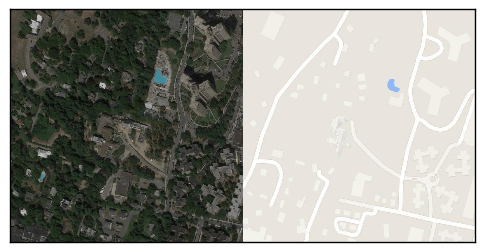

(600, 1200, 3)


In [3]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/maps/train/100.jpg')
imshow_multi([image])

print image.shape


In [4]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

dir = '../data/maps/train'
image_names = [os.path.join(dir, name) for name in os.listdir(dir) if name.endswith('.jpg')]

def create_qs(image_names):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    filename_q = tf.train.slice_input_producer([filename_tensor], num_epochs=None, shuffle=True)[0]

    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.cast(image_255, tf.float32) / 255.0 # images are 1200x600x3
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE*2, 3])
    source = tf.slice(image, [0, 0, 0], [-1, IMAGE_SIZE, -1])
    target = tf.slice(image, [0, IMAGE_SIZE, 0], [-1, IMAGE_SIZE, -1])
    # combine source and target into the same image with 6 channels:
    combined = tf.concat(2, [source, target])
    cropped = tf.random_crop(combined, [CROPPED_SIZE, CROPPED_SIZE, 6])
    # separate them:
    source = tf.slice(cropped, [0, 0, 0], [CROPPED_SIZE, CROPPED_SIZE, 3])
    target = tf.slice(cropped, [0, 0, 3], [CROPPED_SIZE, CROPPED_SIZE, 3])

    source_batch, target_batch = tf.train.shuffle_batch([source, target], batch_size=BATCH_SIZE, capacity=512, min_after_dequeue=256)
    
    source_batch = tf.image.resize_bilinear(source_batch, [RESIZE_TO, RESIZE_TO])
    target_batch = tf.image.resize_bilinear(target_batch, [RESIZE_TO, RESIZE_TO])
    
    return source_batch, target_batch

source_batch, target_batch = create_qs(image_names)


In [5]:
session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-14, started daemon 140442133849856)>,
 <Thread(Thread-15, started daemon 140442125457152)>]

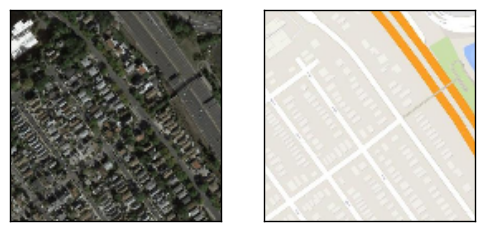

In [6]:
%matplotlib inline

srcs_, tgts_ = session.run([source_batch, target_batch])
imshow_multi([srcs_[0], tgts_[0]])

In [7]:

def lrelu(x):
    # leaky relu
    alpha = 0.1
    return tf.maximum(alpha*x,x)

def create_conv(input, out_channels, patch_size=4, stride=2, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=bias_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv + b

def create_deconv(input, out_channels, patch_size=4, stride=2, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=bias_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')
        return deconv + b

def create_fc(input, out_channels, name='fc'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        w = tf.get_variable('w', shape=[in_channels, out_channels], initializer=xavier_initializer())
        b = tf.get_variable('b', shape=[out_channels], initializer=bias_init)
        return tf.matmul(input, w) + b
    
def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def flatten_tensor(t):
    shape = [s.value for s in t.get_shape()]
    flat_size = 1
    for x in shape[1:]:
        flat_size *= x
    return tf.reshape(t, [-1, flat_size])


In [8]:

def create_unet(image, name='unet'):
    with tf.variable_scope(name):
        downscaled_images = [image]
        for i, n_channels in enumerate(ENCODER_LAYERS):
            image = create_conv(image, n_channels, name='downscale'+str(i))
            image = lrelu(image)
            image = create_batch_norm(image, name='downbn'+str(i))
            downscaled_images.append(image)
        for i, n_channels in enumerate(list(reversed(ENCODER_LAYERS[:-1])) + [32]):
            u_layer = downscaled_images[-(i+2)]
            image = create_deconv(image, n_channels, name='upscale'+str(i))
            image = lrelu(image)
            image = create_batch_norm(image, name='upbn'+str(i))
            image = tf.concat(3, [image, u_layer])
        image = lrelu(create_conv(image, 32, patch_size=1, stride=1, name='color1'))
        image = create_conv(image, 3, patch_size=1, stride=1, name='color2')
        return tf.nn.tanh(image)

def create_critic(image, name='critic', reuse=False):
    # the critic should take in 6-channel images -- the generated image and the source image, concatenated
    with tf.variable_scope(name, reuse=reuse):
        for i, n_channels in enumerate(DISC_LAYERS):
            image = create_conv(image, n_channels, name='conv'+str(i))
            image = lrelu(image)
            image = create_batch_norm(image, name='bn'+str(i))
        fc1 = create_fc(flatten_tensor(image), 64, name='fc1')
        fc1 = lrelu(fc1)
        return tf.reshape(create_fc(fc1, 1, name='fc2'), [-1])

def create_critic_outputs(generated_image, ground_truth_image, source_image):
    real = tf.concat(3, [source_batch, ground_truth_image])
    gen = tf.concat(3, [source_batch, generated_image])
    
    def random_crop_across_batches(images):
        return tf.map_fn(lambda img: tf.random_crop(img, [DISC_TILE_SIZE, DISC_TILE_SIZE, 6]), images)
    
    real_crops = random_crop_across_batches(tf.tile(real, [N_DISC_PATCHES, 1, 1, 1]))
    gen_crops = random_crop_across_batches(tf.tile(gen, [N_DISC_PATCHES, 1, 1, 1]))
    
    real_output = tf.reduce_mean(create_critic(real_crops))
    fake_output = tf.reduce_mean(create_critic(gen_crops, reuse=True))
    return real_output, fake_output
    
scope = 'pix30'
with tf.variable_scope(scope):
    gen_lr = tf.placeholder_with_default(tf.constant(5e-4), [], name='gen_lr')
    critic_lr = tf.placeholder_with_default(tf.constant(5e-4), [], name='critic_lr')
    
    generated_batch = create_unet(source_batch)
    
    real_critic_output, fake_critic_output = create_critic_outputs(generated_batch, target_batch, source_batch)
    l1_loss = tf.reduce_mean(tf.abs(generated_batch - target_batch))
    
    gen_loss = l1_loss * L1_WEIGHT - fake_critic_output
    critic_loss = fake_critic_output - real_critic_output
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    critic_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope+'/critic')
    weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in critic_vars])
    train_critic_op = tf.train.RMSPropOptimizer(critic_lr).minimize(critic_loss, var_list=critic_vars)
    train_critic = tf.group(weight_clip_op, train_critic_op)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope+'/unet')
    train_gen = tf.train.RMSPropOptimizer(gen_lr).minimize(gen_loss, global_step=global_step, var_list=gen_vars)
    
    examples = tf.concat(2, [source_batch, target_batch, generated_batch])
    


In [9]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    save_path = None # 'models/pix2pix-sat2map-4'
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)
    tf.train.start_queue_runners(sess=session)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()

Will not save progress


Step: 160, critic loss: -5.54334342241


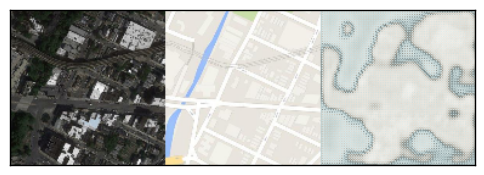

Step: 180, critic loss: -5.88030837536


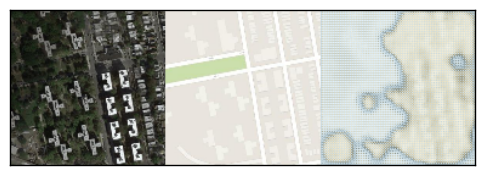

Step: 200, critic loss: -5.37879656792


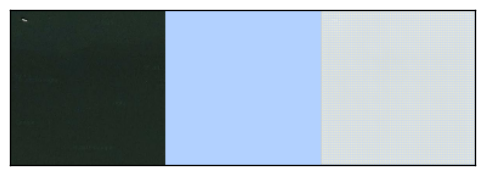

Step: 220, critic loss: -6.25252151728


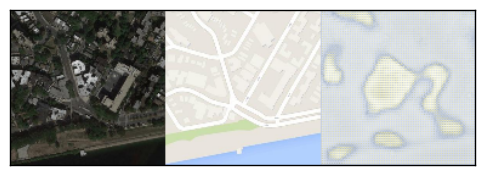

Step: 240, critic loss: -4.81304647684


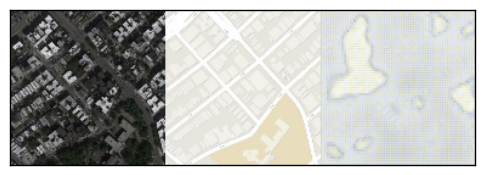

Step: 260, critic loss: -5.25953490019


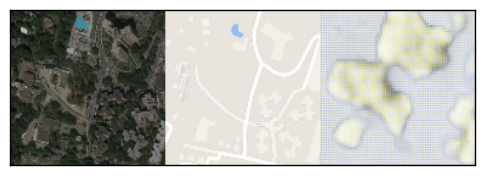

Step: 280, critic loss: -5.96240045905


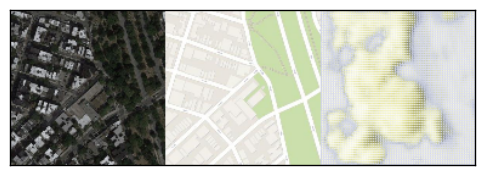

Step: 300, critic loss: -6.09831613541


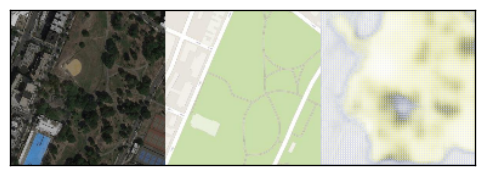

Step: 320, critic loss: -4.66668368101


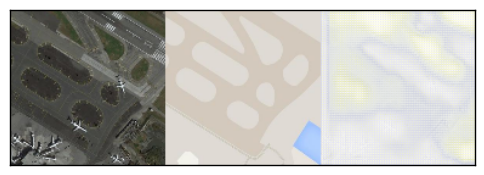

Step: 340, critic loss: -5.22124688506


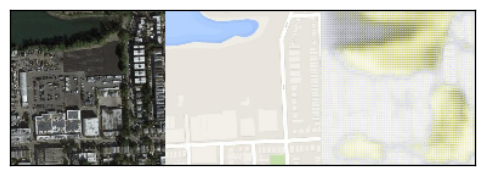

Step: 360, critic loss: -5.8324568373


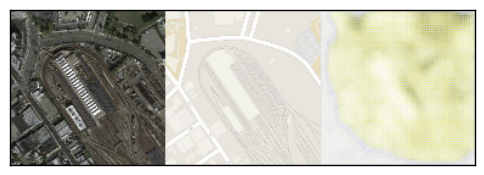

Step: 380, critic loss: -6.20247891188


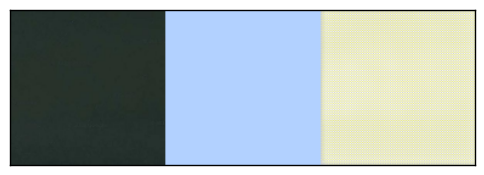

Step: 400, critic loss: -6.414351089


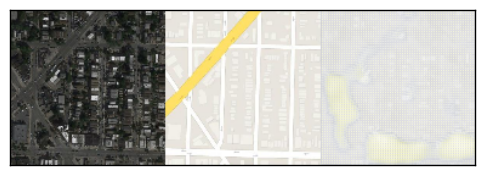

Step: 420, critic loss: -4.20772056699


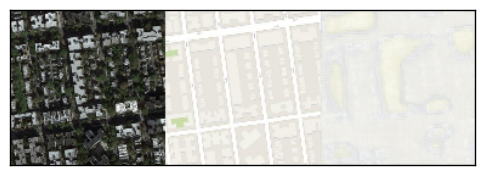

Step: 440, critic loss: -5.92973707676


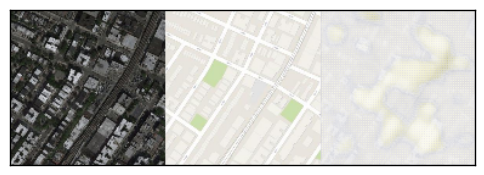

Step: 460, critic loss: -6.27168567896


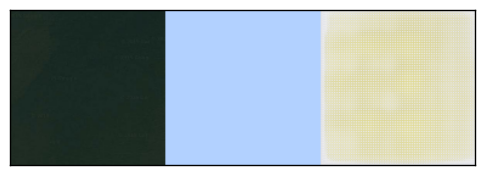

Step: 480, critic loss: -5.88864914536


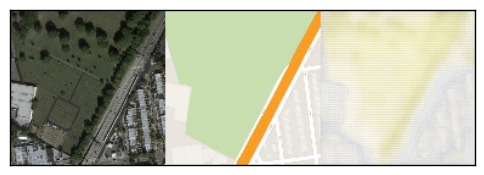

Step: 500, critic loss: -4.32215836644


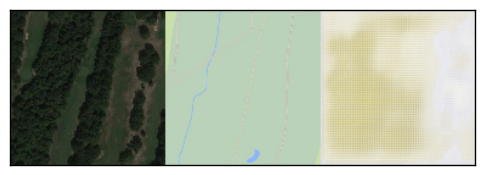

Step: 520, critic loss: -6.15468029857


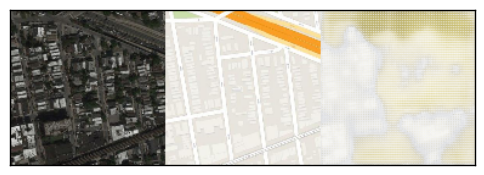

Step: 540, critic loss: -6.57376401544


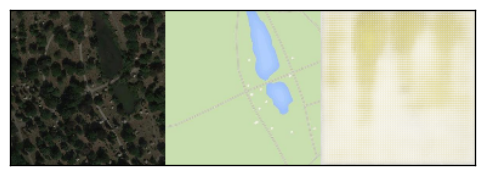

Step: 560, critic loss: -5.87680030942


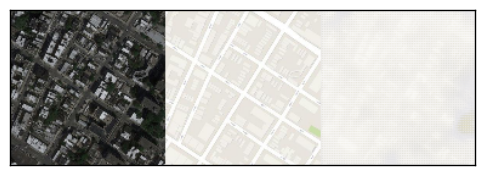

KeyboardInterrupt: 

In [12]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))

savecount = 0

losses = []

while True:
    examples_ = None
    step_ = global_step.eval()
    
    # for _ in xrange(50 if step_ < 25 or step_ % 500 == 0 else 5):
    for _ in xrange(5):
        critic_loss_, _ = session.run([critic_loss, train_critic])
        losses.append(critic_loss_)
    
    session.run(train_gen)
    
    if step_ % 20 == 0:
        print "Step: {}, critic loss: {}".format(step_, avg(losses))
        losses = []
            
        examples_ = session.run(examples[:1])
        
        if step_ % 20 == 0:
            imshow_multi(list(examples_))
        
        if step_ % 200 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
                savecount += 1
                if savecount > 4:
                    create_session()
                    savecount = 0


In [ ]:
examples_ = session.run(examples[:1])
imshow_multi(list(examples_))